In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
#Možnosť zadať číslo vlny 1-4, ktoré určí, s ktorým datasetom chceme pracovať.
option = input("Zadaj číslo vlny (1, 2, 3, 4): ")
#V premennej filename sa zostaví názov súboru, ktorý neskôr použijeme pri vytvorení cesty k súboru na disku.
filename = f"{option}_vlna.xlsx"
print(f"Načítavam súbor: {filename}")
#Premenná load_file definuje cestu k súboru.
load_file = f"/content/drive/MyDrive/bp-TomasKlein/{filename}"
#Načítanie datasetu do premennej df1.
df1 = pd.read_excel(load_file)

Zadaj číslo vlny (1, 2, 3, 4): 4
Načítavam súbor: 4_vlna.xlsx


In [3]:
#Získanie zoznamu boolean atribútov teda takých, ktorých hodnoty sú True alebo False.
bool_columns = df1.select_dtypes(include=['bool']).columns.tolist()
print("Stĺpce s hodnotami True/False:", bool_columns)
#Konvertujem boolean atribúty True na hodnotu 1 a False na hodnotu 0 dátového typu Integer.
df1[bool_columns] = df1[bool_columns].astype(int)

Stĺpce s hodnotami True/False: ['Fajčenie', 'Alkohol', 'Hypertenzia', 'Kardiovaskulárne ochorenia']


In [4]:
from sklearn.preprocessing import OneHotEncoder

#Vytvorím si OneHotEncoder, kde nastavím sparse_output=False, aby výstupom nebola sparse matica, ale numpy.ndarray.
encoder = OneHotEncoder(sparse_output=False)

#Fitovanie a transformácia atribútu 'Pohlavie' pomocou enkoderu.
pohlavie_encoded = encoder.fit_transform(df1[["Pohlavie"]])

#Získanie názvov nových atribútov na základe hodnôt pôvodného atribútu 'Pohlavie'.
encoded_feature_names = encoder.get_feature_names_out(["Pohlavie"])

#Vytvorenie nového DF (pohlavie_df) pre zakódované hodnoty s novými názvami stĺpcov a indexom zhodným s pôvodným DF.
#(index=df1.index zabezpečuje, že nový DF má rovnaké poradie riadkov ako df1)
pohlavie_df = pd.DataFrame(pohlavie_encoded, columns=encoded_feature_names, index=df1.index)

#Pridanie nových atribútov z pohlavie_df do pôvodného df1 (bez pôvodného stĺpca 'Pohlavie', axis=1 spojenie po stĺpcoch teda horizontálne).
df1 = pd.concat([df1.drop(columns=["Pohlavie"]), pohlavie_df], axis=1)

In [5]:
#Odstránenie záznamov s chýbajúcimi hodnotami v cieľovom atribúte a zachovanie zmeny priamo v df1 (inplace=True).
#(subset= kontrolujeme iba tento stĺpec na prítomnosť chýbajúcich hodnôt)
df1.dropna(subset=["Závažnosť priebehu ochorenia"], inplace=True)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

#Vyberieme numerické atribúty okrem cieľového atribútu do premennej num_cols.
num_cols = df1.select_dtypes(include=["number"]).drop(columns=["Závažnosť priebehu ochorenia","Poradie"]).columns

#Zistíme počet chýbajúcich hodnôt v numerických atribútoch.
missing = df1[num_cols].isnull().sum()

#Výpočet percent chýbajúcich hodnôt.
missing_percent = 100 * missing / len(df1)

#Vytvorenie tabuľky s prehľadom o počte a percentách chýbajúcich hodnôt, ktorú si zoradíme podľa najviac chýbajúcich hodnôt jednotlivých atribútov.
missing_df = pd.DataFrame({"Počet chýbajúcich hodnôt": missing,"Percento": missing_percent}).sort_values(by="Počet chýbajúcich hodnôt", ascending=False)

#Výpis tabuľky.
print("Chýbajúce hodnoty v číselných atribútoch:")
print(missing_df)

Chýbajúce hodnoty v číselných atribútoch:
                            Počet chýbajúcich hodnôt   Percento
S-CK-MB last                                     409  32.772436
S-CK-MB min                                      409  32.772436
S-CK-MB max                                      409  32.772436
S-CK-MB first                                    409  32.772436
S-CK last                                        377  30.208333
...                                              ...        ...
Alkohol                                            0   0.000000
Kardiovaskulárne ochorenia                         0   0.000000
Hypertenzia                                        0   0.000000
Pohlavie_Muž                                       0   0.000000
Pohlavie_Žena                                      0   0.000000

[80 rows x 2 columns]


<ipython-input-7-e5fae261a0c4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=missing_df.head(30), x="Počet chýbajúcich hodnôt", y=missing_df.head(30).index, palette="flare")


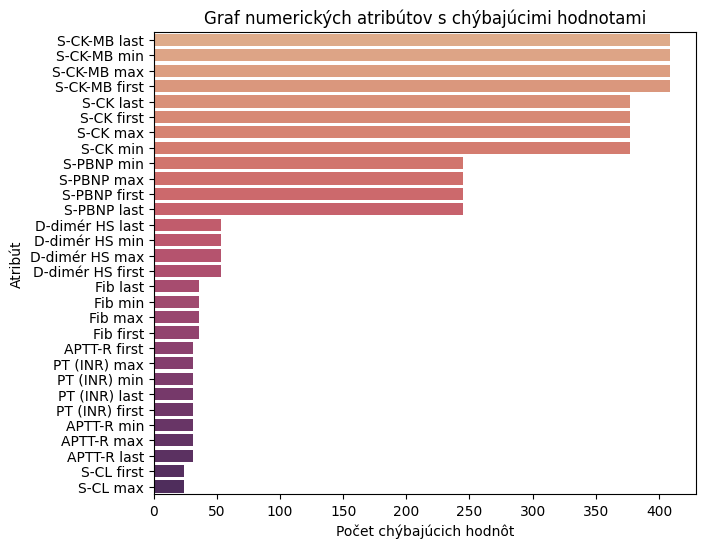

In [7]:
#Graf 30 atribútov a ich počet chýbajúcich hodnôt, ktorý je zoradený od tých atribútov, kde chýba najviac záznamov.
plt.figure(figsize=(7, 6))
sns.barplot(data=missing_df.head(30), x="Počet chýbajúcich hodnôt", y=missing_df.head(30).index, palette="flare")
plt.xlabel("Počet chýbajúcich hodnôt")
plt.ylabel("Atribút")
plt.title("Graf numerických atribútov s chýbajúcimi hodnotami")
plt.show()

In [8]:
#Vytvorím si funkciu na stratifikované doplnenie chýbajúcich hodnôt priemerom skupiny.
def dopln_chybajuce(x):
  priemer = x.mean()  #Vypočítame priemer hodnôt v stĺpci.
  return x.fillna(priemer)  #Nahradíme chýbajúce hodnoty priemerom.

#Rozdelím dáta podľa skupiny hodnôt cieľového atribútu
skupina = df1.groupby('Závažnosť priebehu ochorenia')
#Aplikácia funkcie na df1, pre každú skupinu doplníme chýbajúce hodnoty priemerom príslušnej skupiny.
df1[num_cols] = skupina[num_cols].transform(dopln_chybajuce)

#Kontrola doplnenia chýbajucich hodnôt.
print("\nChýbajúce hodnoty v číselných atribútoch po ich doplnení:")
print(df1[num_cols].isnull().sum())


Chýbajúce hodnoty v číselných atribútoch po ich doplnení:
Vek              0
Fajčenie         0
Alkohol          0
S-Na first       0
S-Na last        0
                ..
S-CK last        0
S-CK min         0
S-CK max         0
Pohlavie_Muž     0
Pohlavie_Žena    0
Length: 80, dtype: int64


<ipython-input-9-91c79f0f7439>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['1. Prepustený do domáceho liečenia,\n ev. soc. zariadenia', '2. Preložený na iné oddelenie', '3. Exitus (úmrtie)'])
<ipython-input-9-91c79f0f7439>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['1. Prepustený do domáceho liečenia,\n ev. soc. zariadenia', '2. Preložený na iné oddelenie', '3. Exitus (úmrtie)'])
<ipython-input-9-91c79f0f7439>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['1. Prepustený do domáceho liečenia,\n ev. soc. zariadenia', '2. Preložený na iné oddelenie', '3. Exitus (úmrtie)'])
<ipython-input-9-91c79f0f7439>:27: UserWarning: set_ticklabels() should only be used with a fi

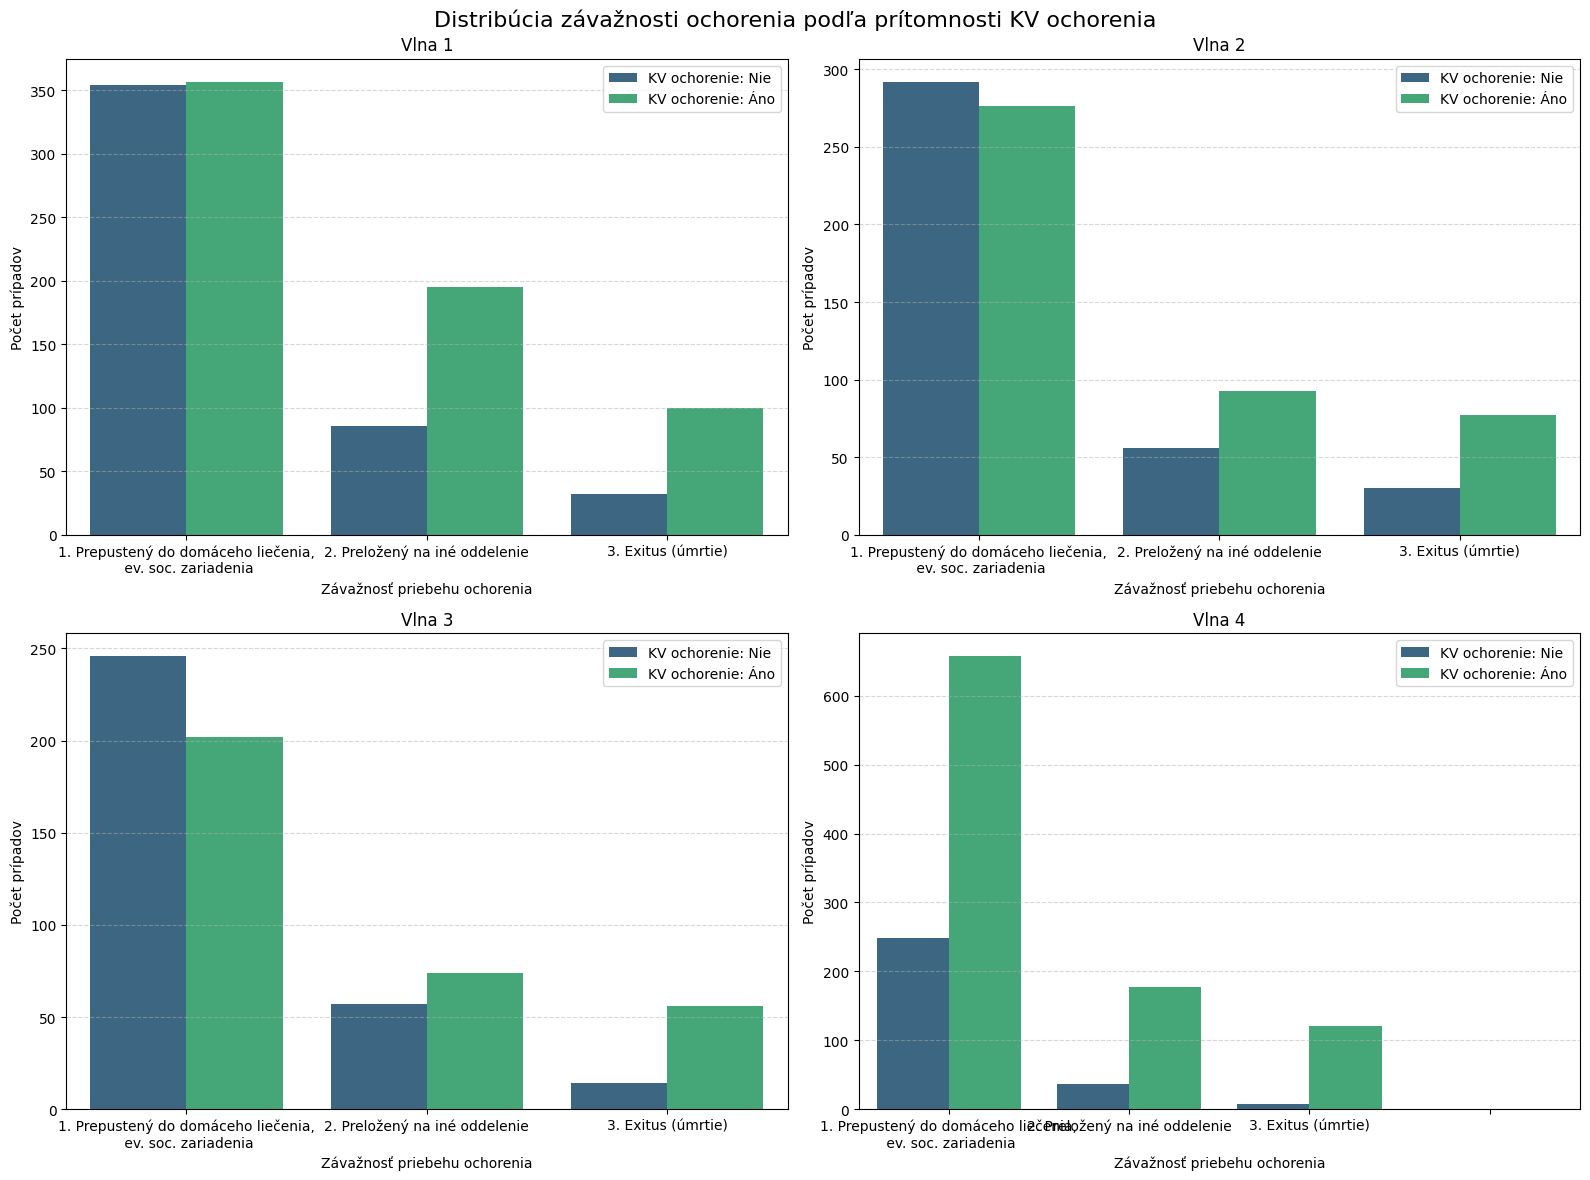

In [9]:
# Načítanie všetkých štyroch vln pre vytvorenie jednotného grafu distribúcie závažnosti ochorenia podľa prítomnosti KV ochorenia.
vlny = []
for i in range(1, 5):
    #Načítame dataset a pridáme ho do zoznamu.
    df = pd.read_excel(f"/content/drive/MyDrive/bp-TomasKlein/{i}_vlna.xlsx")
    vlny.append(df) #Pridáme df do zoznamu.

#Vytvorenie priestoru 4 grafov s veľkosťou 18,12.
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
#Hlavný nadpis.
plt.suptitle('Distribúcia závažnosti ochorenia podľa prítomnosti KV ochorenia',fontsize=16)

#Cyklus pre vytvorenie grafov pre každú vlnu.
for i in range(4):
    ax = axes[i//2, i%2] #Výber osi pomocou celočíselného delenia // pre riadok a zvyšku % pre stĺpec.
    df = vlny[i] #Načítanie dát do premennej df pre aktuálnu vlnu.

    sns.countplot(x='Závažnosť priebehu ochorenia', #Premenná pre os x.
        hue='Kardiovaskulárne ochorenia', #Rozdelenie podľa farieb.
        data=df, palette='viridis',order=sorted(df['Závažnosť priebehu ochorenia']),
        ax=ax #Os na ktorú sa má vykresleniť vlna.
        )

    ax.set_title(f'Vlna {i+1}')
    ax.set_ylabel('Počet prípadov')
    plt.tight_layout()
    ax.set_xticklabels(['1. Prepustený do domáceho liečenia,\n ev. soc. zariadenia', '2. Preložený na iné oddelenie', '3. Exitus (úmrtie)'])
    ax.legend(labels=['KV ochorenie: Nie', 'KV ochorenie: Áno'])
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [10]:
from scipy.stats import chi2_contingency

#Vytvorenie zoznamu na ukladanie výsledkov všetkých vĺn.
results = []

for wave_num in range(1, 5):
    file_path = f"/content/drive/MyDrive/bp-TomasKlein/{wave_num}_vlna.xlsx"
    wave_data = pd.read_excel(file_path)

    #Vytvorenie kontingenčnej tabuľky početnosti pre kombinácie kategórií.
    contingency_table = pd.crosstab(wave_data['Závažnosť priebehu ochorenia'], wave_data['Kardiovaskulárne ochorenia'])

    #Chi-kvadrátový testu nezávislosti.
    #expected = tabuľka očakávaných frekvencií.
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    #Uloženie výsledkov testu.
    results.append({"Vlna": f"Vlna {wave_num}","Chi²": round(chi2, 3),"p-hodnota": p,
                    "Stupne voľnosti": dof, #dof: stupne voľnosti (počet riadkov-1 * počet stĺpcov-1).
                    "Významný rozdiel": "Áno" if p < 0.05 else "Nie"}) #Podmienka výsledku pre p hodnotu a veľkosť 0.05.

    #Výpis očakávaných frekvencií.
    print(f"\nOčakávané frekvencie pre Vlnu {wave_num}")
    expected_df = pd.DataFrame(expected.round(2),index=contingency_table.index,#Názvy riadkov pôvodnej tabuľky.
                               columns=contingency_table.columns)  #Názvy stlpcov pôvodnej tabuľky.
    print(expected_df.to_string())

#Vytvorenie tabuľky výsledkov.
results_df = pd.DataFrame(results)
print("\nVýsledky chi-kvadrátového testu nezávislosti")
print(results_df[["Vlna", "Chi²", "p-hodnota", "Stupne voľnosti", "Významný rozdiel"]].to_string(index=False))


Očakávané frekvencie pre Vlnu 1
Kardiovaskulárne ochorenia     False   True 
Závažnosť priebehu ochorenia                
1                             298.57  412.43
2                             118.00  163.00
3                              55.43   76.57

Očakávané frekvencie pre Vlnu 2
Kardiovaskulárne ochorenia     False   True 
Závažnosť priebehu ochorenia                
1                             260.56  307.44
2                              68.35   80.65
3                              49.08   57.92

Očakávané frekvencie pre Vlnu 3
Kardiovaskulárne ochorenia     False   True 
Závažnosť priebehu ochorenia                
1                             218.82  229.18
2                              63.99   67.01
3                              34.19   35.81

Očakávané frekvencie pre Vlnu 4
Kardiovaskulárne ochorenia     False   True 
Závažnosť priebehu ochorenia                
1.0                           212.21  694.79
2.0                            49.84  163.16
3.0          

In [11]:
#Vytváram si premennú do ktorej dám všetky numerické atribúty, okrem poradia.
df1_numeric = df1.select_dtypes(include=["number"]).drop('Poradie',axis=1)

from sklearn.model_selection import train_test_split

#Premenné pre tvorbu modelov.
X = df1_numeric.drop(columns=["Závažnosť priebehu ochorenia"])
y = df1_numeric["Závažnosť priebehu ochorenia"]

#Rozdelenie datasetu na trénovaciu a testovaciu časť v pomere 70-30.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<ipython-input-12-afd589d700d6>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top20_rf.values, y=rf_dolezite_atr.head(20).index, palette="flare")


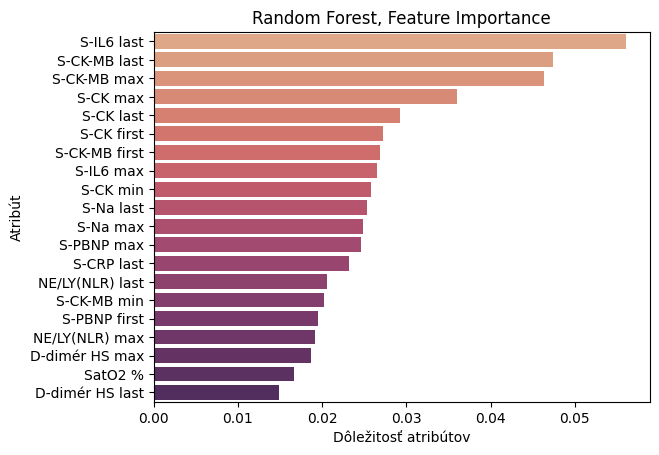


20 najviac ovpyvňujúcich atribútov podľa Random Forest, Feature Importance:

S-IL6 last         0.056079
S-CK-MB last       0.047417
S-CK-MB max        0.046389
S-CK max           0.036003
S-CK last          0.029277
S-CK first         0.027213
S-CK-MB first      0.026817
S-IL6 max          0.026507
S-CK min           0.025762
S-Na last          0.025309
S-Na max           0.024852
S-PBNP max         0.024631
S-CRP last         0.023222
NE/LY(NLR) last    0.020543
S-CK-MB min        0.020209
S-PBNP first       0.019537
NE/LY(NLR) max     0.019123
D-dimér HS max     0.018738
SatO2 %            0.016692
D-dimér HS last    0.014836
dtype: float64 



In [12]:
from sklearn.ensemble import RandomForestClassifier
#Vytvorenie Random Forest modelu.
#n_estimators=100 je počet rozhodovacích stromov.
rf = RandomForestClassifier(n_estimators=100, random_state=42)
#Trénovanie modelu.
rf.fit(X_train, y_train)

#Výpočet dôležitosti atribútov feature importance.
#rf.feature_importances_ vracia pole s dôležitosťou každého atribútu.
rf_dolezite_atr = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

#Pre graf a aj výpis použijem iba 20 najdôležitejších.
top20_rf = rf_dolezite_atr.head(20)

#Vytvorenie grafu pre 20 najviac ovpyvňujúcich atribútov.
sns.barplot(x=top20_rf.values, y=rf_dolezite_atr.head(20).index, palette="flare")
plt.xlabel("Dôležitosť atribútov")
plt.ylabel("Atribút")
plt.title("Random Forest, Feature Importance")
plt.show()

print("\n20 najviac ovpyvňujúcich atribútov podľa Random Forest, Feature Importance:\n")
print(top20_rf,"\n")

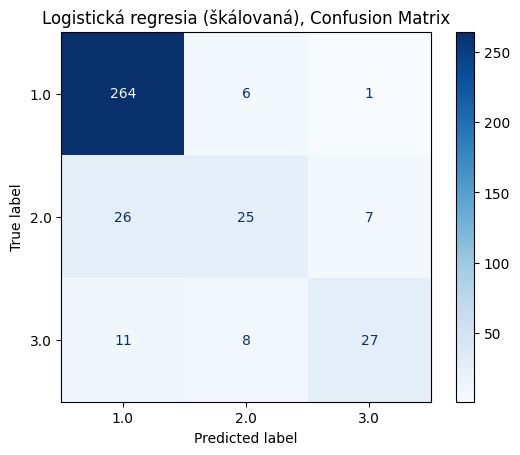


Logistická regresia (škálovaná), Classification Report:

              precision    recall  f1-score   support

         1.0       0.88      0.97      0.92       271
         2.0       0.64      0.43      0.52        58
         3.0       0.77      0.59      0.67        46

    accuracy                           0.84       375
   macro avg       0.76      0.66      0.70       375
weighted avg       0.83      0.84      0.83       375

Logistická regresia AUC-ROC score pre jednotlivé foldy: [0.8098 0.8871 0.8585 0.9196 0.8541]
Priemerné AUC-ROC pre logistickú regresiu: 0.8658


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

binary_cols = []

#Zistím všetky unikátne hodnoty v atibúte, ak sú iba 0 a 1 tak su binárne a tie škálovať nechcem.
for col in X_train.columns:
    if list(X_train[col].unique()) == [0, 1]:
        binary_cols.append(col)
#Vytvorenie zoznamu atribútov na škálovanie okrem binárnych.
cols_to_scale = []
for col in X_train.columns:
  if col not in binary_cols:
    cols_to_scale.append(col)

#Škálované dáta su nastavené tak aby mali priemer 0 a štandardnú odchýlku 1.
scaler = StandardScaler()
#Vytvorenie nových premenných použitých v logistickej regresii.
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
#Aplikácia škálovania do nových vytvorených premenných.
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
#Vytvorenie modelu logistickej regresie pre viac tried One-vs-Rest.
#solver = "liblinear", ktorý je vhodný k One-vs-Rest a menšie datasety.
lr_model = OneVsRestClassifier(LogisticRegression(solver="liblinear",max_iter=1000))
#Trénovanie modelu na škálovaných dátach.
lr_model.fit(X_train_scaled, y_train)
#Predikcia na testovacích dátach.
y_pred_lin = lr_model.predict(X_test_scaled)
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
#Vytvorenie confusion matrix, kde porovnávame predikované a skutočnéh hodnoty.
cm = confusion_matrix(y_test, y_pred_lin)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot(cmap="Blues")
plt.title("Logistická regresia (škálovaná), Confusion Matrix")
plt.show()


from sklearn.metrics import classification_report
#Metriky z klasifikačného reportu.
report = classification_report(y_test, y_pred_lin)
print("\nLogistická regresia (škálovaná), Classification Report:\n")
print(report)

#Krížová validácia, foldy = počet častí na, ktoré sa trénovacia časť dát rozdelí.
#Vykoná sa 5 iterácii, v každej sa 4 časti použiju na trénovanie a 1 na testovanie.
#Výsledok je AUC-ROC skóre pre každý z 5 foldov.
cv_folds = 5
lr_auc_scores = cross_val_score(lr_model,X_train_scaled,y_train,cv=cv_folds,scoring='roc_auc_ovr')
print("Logistická regresia AUC-ROC score pre jednotlivé foldy:", lr_auc_scores.round(4))
print("Priemerné AUC-ROC pre logistickú regresiu:", lr_auc_scores.mean().round(4))


In [14]:
import statsmodels.api as sm
import numpy as np

#Pridanie do premennej unikatne hodnoty tried.
triedy = sorted(y_train.unique())

#Vytvorím si prázdne tabuľky pre zápis výsledkov. Jednu pre p hodnoty jednu pre koeficienty.
vsetky_p = pd.DataFrame(index=X_train_scaled.columns)
vsetky_koef = pd.DataFrame(index=X_train_scaled.columns)

print("Analýza pre každú triedu:")

#Cyklus kde pre každú triedu spustíme samostatnú logistickú regresiu.
for trieda in triedy:
    print(f"\nTrieda {trieda}:")

    #Vytvorím si binárny cieľ: 1 pre aktuálnu triedu, 0 pre ostatné.
    y_bin = (y_train == trieda).astype(int)

    #Pridám konštantu k vstupným dátam.
    X = sm.add_constant(X_train_scaled)

    #Vytvorím a natrénujeme logistický regresný model.
    model = sm.Logit(y_bin, X)
    vysledok = model.fit_regularized(method='l1', alpha=0.01, disp=False)

    # Uložím koeficienty a p-hodnoty bez konštanty.
    koef = vysledok.params.drop('const', errors='ignore')
    p_val = vysledok.pvalues.drop('const', errors='ignore')

    #Pridanie výsledkov do tabuliek.
    vsetky_koef[f"Trieda {trieda}"] = koef
    vsetky_p[f"Trieda {trieda}"] = p_val


Analýza pre každú triedu:

Trieda 1.0:


/usr/local/lib/python3.11/dist-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 48 out of 81 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Trieda 2.0:


/usr/local/lib/python3.11/dist-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 32 out of 81 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Trieda 3.0:


/usr/local/lib/python3.11/dist-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 43 out of 81 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [15]:
#Vytvorim kombinovaný výpis koeficientov a p-hodnôt.
kombinovane = vsetky_koef.head(5).copy()
for stlpec in kombinovane.columns:
    p_stlpec = stlpec
    #Spojenie koeficientov a p-hodnoty do jedného reťazca.
    kombinovane[stlpec] = (vsetky_koef[stlpec].round(4).astype(str) + " (" + vsetky_p[p_stlpec].round(4).astype(str) + ")")

#Zobrazenie tabuľky v ktorej sú p hodnoty a koeficient zároveň.
display(kombinovane.style.set_caption("Kombinované výsledky: koeficient a (p-hodnota)"))

# Najvýznamnejšie atribúty
print("\nNajviac vplyvné atribúty pre každú triedu:")
for trieda in triedy:
    p_stlpec = f"Trieda {trieda}"
    koef_stlpec = f"Trieda {trieda}"
    #Vyberám len významné atribúty, ktorých p-hodnota < 0.05.
    maska = vsetky_p[p_stlpec] < 0.05
    #Najvplyvnejšie vyberám podľa absolútnej hodnoty koeficientu. Kladná hodnota koef zabezpečuje že atribút ovplyvňuje či bude do triedy patriť a záporna naopak.
    top = vsetky_koef[koef_stlpec][maska].abs().sort_values(ascending=False).head(5)

    #Ak sme našli vôbec nejaké významné atribúty.
    if len(top) > 0:
        print(f"\nTrieda {trieda}:")
        #Vytvoríme tabuľku pre výsledky.
        df_top = pd.DataFrame({'Atribút': top.index,
            'Koeficient': [f"{vsetky_koef.loc[atribut, koef_stlpec]:.4f}" for atribut in top.index],
            'P-hodnota': [f"{vsetky_p.loc[atribut, p_stlpec]:.4f}" for atribut in top.index]})
        display(df_top)
    else:
        print(f"\nTrieda {trieda}: Žiadne významné atribúty")

,Trieda 1.0,Trieda 2.0,Trieda 3.0
Vek,-0.1367 (0.4998),0.152 (0.4113),0.7007 (0.1789)
Fajčenie,-0.1435 (0.7007),0.4054 (0.2452),-0.5714 (0.5839)
Alkohol,0.0426 (0.9202),0.4367 (0.2488),-1.5718 (0.1246)
S-Na first,0.3674 (0.4708),-0.6607 (0.1395),-4.3386 (0.008)
S-Na last,-0.019 (0.964),-0.7808 (0.0292),1.026 (0.2875)



Najviac vplyvné atribúty pre každú triedu:

Trieda 1.0:


,Atribút,Koeficient,P-hodnota
0,S-CK first,31.3048,0.0000
1,S-CK max,-29.5882,0.0000
2,S-CK min,-16.8579,0.0000
3,S-CK last,15.1162,0.0000
4,S-CK-MB last,-5.8714,0.0000



Trieda 2.0:


,Atribút,Koeficient,P-hodnota
0,S-CK max,40.1030,0.0000
1,S-CK first,-39.1203,0.0000
2,S-CK min,19.6061,0.0000
3,S-CK last,-18.8197,0.0000
4,S-CK-MB last,4.2375,0.0003



Trieda 3.0:


,Atribút,Koeficient,P-hodnota
0,S-CK max,-59.6149,0.0004
1,S-CK first,43.9929,0.0169
2,S-CK last,25.5017,0.0009
3,S-CK min,-21.2990,0.0188
4,S-Na first,-4.3386,0.0080


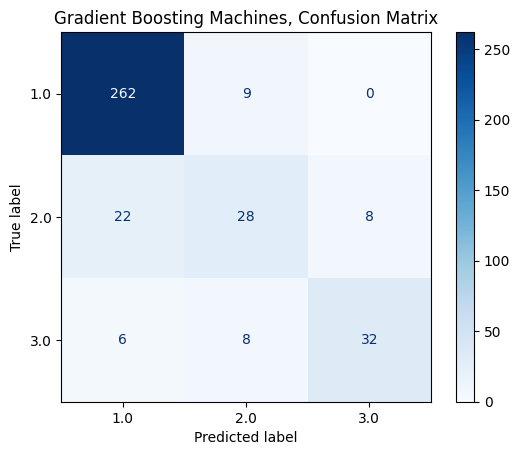


Gradient Boosting Machines Classification Report:

              precision    recall  f1-score   support

         1.0       0.90      0.97      0.93       271
         2.0       0.62      0.48      0.54        58
         3.0       0.80      0.70      0.74        46

    accuracy                           0.86       375
   macro avg       0.78      0.72      0.74       375
weighted avg       0.85      0.86      0.85       375

GBM AUC-ROC score pre jednotlivé foldy: [0.89521337 0.95324751 0.95958599 0.94192613 0.94313971]
Priemerné AUC-ROC pre GBM: 0.9386225445522275


In [16]:
from sklearn.ensemble import GradientBoostingClassifier

#Vytvorenie modelu GBM, n_estimators=100 je počet rozhodovacích stromov.
gbm = GradientBoostingClassifier(n_estimators=100, random_state=42)
#Trénovanie modelu.
gbm.fit(X_train, y_train)
#Predikcia modelu na testovacích dátach.
y_pred_gbm = gbm.predict(X_test)

cm_gbm = confusion_matrix(y_test, y_pred_gbm)

disp_gbm = ConfusionMatrixDisplay(confusion_matrix=cm_gbm, display_labels=gbm.classes_)
disp_gbm.plot(cmap="Blues")
plt.title("Gradient Boosting Machines, Confusion Matrix")
plt.show()

report_gbm = classification_report(y_test, y_pred_gbm)
print("\nGradient Boosting Machines Classification Report:\n")
print(report_gbm)

gbm_auc_scores = cross_val_score(gbm, X_train, y_train, cv=cv_folds, scoring='roc_auc_ovr')
print("GBM AUC-ROC score pre jednotlivé foldy:", gbm_auc_scores)
print("Priemerné AUC-ROC pre GBM:", gbm_auc_scores.mean())

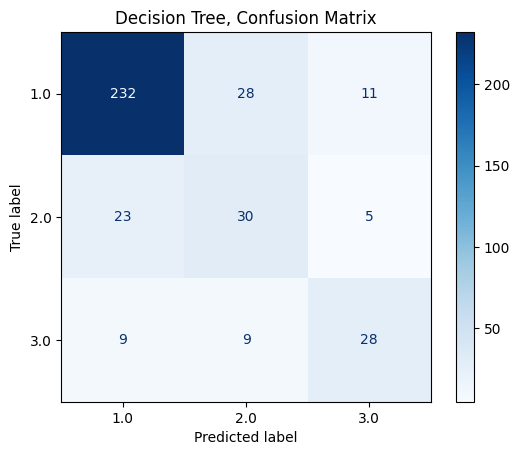


Decision Tree Classification Report:

              precision    recall  f1-score   support

         1.0       0.88      0.86      0.87       271
         2.0       0.45      0.52      0.48        58
         3.0       0.64      0.61      0.62        46

    accuracy                           0.77       375
   macro avg       0.65      0.66      0.66       375
weighted avg       0.78      0.77      0.78       375

Decision Tree AUC-ROC score pre jednotlivé foldy: [0.64874521 0.74783511 0.72699086 0.77568582 0.77561756]
Priemerné AUC-ROC pre Decision Tree: 0.7349749120484471


In [17]:
from sklearn.tree import DecisionTreeClassifier

#Vytvorenie modelu rozhodovacieho stromu.
tree = DecisionTreeClassifier(random_state=42)
#Trénovanie modelu.
tree.fit(X_train, y_train)
#Predikcia modelu na testovacích dátach.
y_pred_tree = tree.predict(X_test)

cm_tree = confusion_matrix(y_test, y_pred_tree)

disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=tree.classes_)
disp_tree.plot(cmap="Blues")
plt.title("Decision Tree, Confusion Matrix")
plt.show()

report_tree = classification_report(y_test, y_pred_tree)
print("\nDecision Tree Classification Report:\n")
print(report_tree)

tree_auc_scores = cross_val_score(tree, X_train, y_train, cv=cv_folds, scoring='roc_auc_ovr')
print("Decision Tree AUC-ROC score pre jednotlivé foldy:", tree_auc_scores)
print("Priemerné AUC-ROC pre Decision Tree:", tree_auc_scores.mean())

In [18]:
from sklearn.tree import export_graphviz
import graphviz

feature_names = X_train_scaled.columns

#Priradzovanie dát pre strom.
dot_data = export_graphviz(tree,out_file=None,feature_names=feature_names,class_names=[str(c) for c in tree.classes_],
    filled=True,        #Farebné vypĺňanie podľa triedy, pre lepšiu prehliadnosť.
    proportion=True,    #Zobrazenie percentuálneho zastúpenia namiesto počtu.
    max_depth=4,         #Orezanie na 4 úrovne pre jednoduchšie zobrazenie.
    rounded = True
)

#Vytvorenie a uloženie stromu.
graph = graphviz.Source(dot_data, format="png")
#Vyrenderovanie teda export stromu do decision_tree.png
graph.render("decision_tree")

'decision_tree.png'

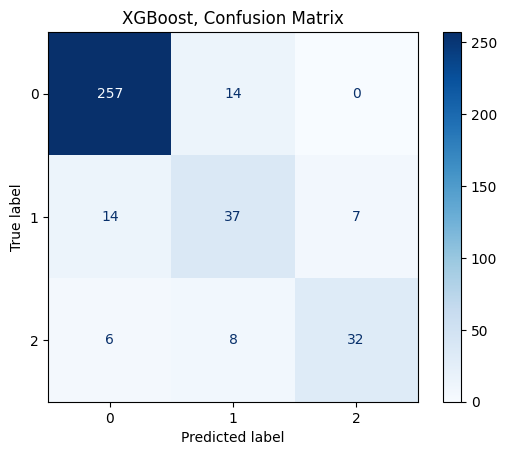


XGBoost Classification Report:
              precision    recall  f1-score   support

         1.0       0.93      0.95      0.94       271
         2.0       0.63      0.64      0.63        58
         3.0       0.82      0.70      0.75        46

    accuracy                           0.87       375
   macro avg       0.79      0.76      0.77       375
weighted avg       0.87      0.87      0.87       375

XGBoost AUC-ROC score pre jednotlivé foldy: [0.92188838 0.96301449 0.95242646 0.94490434 0.93773824]
Priemerné AUC-ROC pre XGBoost: 0.9439943816496463


In [19]:
from xgboost import XGBClassifier

#Úprava cieľových premenných, keďže XGBoost očakáva triedy od 0 a my ich mame od 1.
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

#Vytvorenie modelu XGBoost.
xgb = XGBClassifier(n_estimators=100, random_state=42)
#Trénovanie modelu.
xgb.fit(X_train, y_train_adjusted)
#Trénovanie modelu.
y_pred_xgb = xgb.predict(X_test)

#Spätná transformácia do pôvodných hodnôt tried = 1,2,3.
y_pred_xgb_original = y_pred_xgb + 1

cm_xgb = confusion_matrix(y_test, y_pred_xgb_original)

disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=xgb.classes_)
disp_xgb.plot(cmap="Blues")
plt.title("XGBoost, Confusion Matrix")
plt.show()

report_xgb = classification_report(y_test, y_pred_xgb_original)
print("\nXGBoost Classification Report:")
print(report_xgb)

#y-1 je úprava tried z 1,2,3 na 0,1,2.
xgb_auc_scores = cross_val_score(xgb, X_train, y_train-1, cv=cv_folds, scoring='roc_auc_ovr')
print("XGBoost AUC-ROC score pre jednotlivé foldy:", xgb_auc_scores)
print("Priemerné AUC-ROC pre XGBoost:", xgb_auc_scores.mean())


Vybrané atribúty cez Forward Stepwise Selection:
Index(['Fajčenie', 'S-Na max', 'S-CRP last', 'S-CK-MB last', 'S-CK-MB min',
       'WBC last', 'PLT min', 'PT (INR) min', 'APTT-R max', 'Hypertenzia',
       'S-PBNP min'],
      dtype='object')


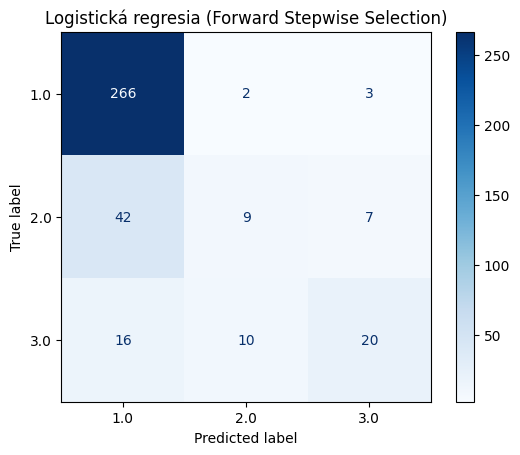


Classification Report LR Forward Stepwise Selection:

              precision    recall  f1-score   support

         1.0       0.82      0.98      0.89       271
         2.0       0.43      0.16      0.23        58
         3.0       0.67      0.43      0.53        46

    accuracy                           0.79       375
   macro avg       0.64      0.52      0.55       375
weighted avg       0.74      0.79      0.75       375


Forward Stepwise Selection AUC-ROC skóre pre jednotlivé foldy: [0.80391 0.83381 0.84469 0.88992 0.8545 ]
Forward Stepwise Selection LR priemerné AUC-ROC: 0.84537


In [20]:
from sklearn.feature_selection import SequentialFeatureSelector

#Vytvorenie základného klasifikátora pre výber atribútov. Môj bude založený na logistickej regresii.
base_estimator = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)

#Forward stepwise selection metóda postupného výberu atribútov.
#Automaticky počet vybraných atribútov, smer výberu je dopredný.
sfs_forward = SequentialFeatureSelector(base_estimator,n_features_to_select="auto",direction='forward',scoring='accuracy', cv=5,n_jobs=-1,tol=1e-4)

#Výber atribútov na trénovacích dátach.
sfs_forward.fit(X_train_scaled, y_train)
#Získanie názvov vybraných atribútov, na základe ich pôvodných názvov.
selected_features = X_train.columns[sfs_forward.get_support()]

print("\nVybrané atribúty cez Forward Stepwise Selection:")
print(selected_features)

#Výber iba vybraných atribútov FSS z pôvodných dát.
X_train_fwd = X_train_scaled[selected_features]
X_test_fwd = X_test_scaled[selected_features]

#Vytvorenie One-vs-Rest klasifikátora pre multi-class triedu.
model_fwd = OneVsRestClassifier(LogisticRegression(solver='liblinear', max_iter=1000, random_state=42))
#Trénovanie už len na vybraných atribútoch.
model_fwd.fit(X_train_fwd, y_train)
#Predikcia novo vytvoreného modelu.
y_pred_fwd = model_fwd.predict(X_test_fwd)

#Vizualizácia CM.
cm = confusion_matrix(y_test, y_pred_fwd)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_fwd.classes_)
disp.plot(cmap="Blues")
plt.title("Logistická regresia (Forward Stepwise Selection)")
plt.show()

#Metriky.
print("\nClassification Report LR Forward Stepwise Selection:\n")
print(classification_report(y_test, y_pred_fwd))

#Krížová validácia.
fwd_lr_auc_scores = cross_val_score(model_fwd,X_train_fwd,y_train,cv=cv_folds,scoring='roc_auc_ovr')
print("\nForward Stepwise Selection AUC-ROC skóre pre jednotlivé foldy:", fwd_lr_auc_scores.round(5))
print("Forward Stepwise Selection LR priemerné AUC-ROC:", fwd_lr_auc_scores.mean().round(5))

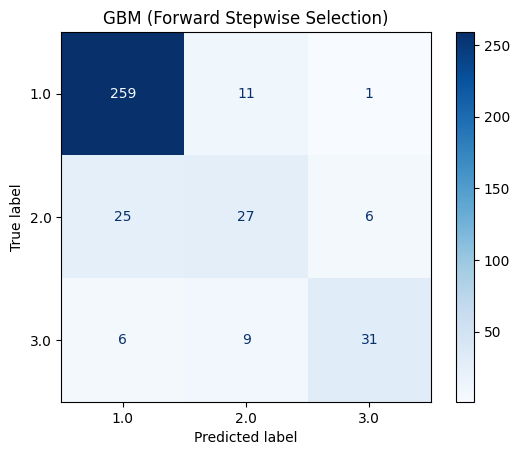


Classification Report GBM FSS:

              precision    recall  f1-score   support

         1.0       0.89      0.96      0.92       271
         2.0       0.57      0.47      0.51        58
         3.0       0.82      0.67      0.74        46

    accuracy                           0.85       375
   macro avg       0.76      0.70      0.73       375
weighted avg       0.83      0.85      0.84       375


Forward Stepwise Selection AUC-ROC skóre pre jednotlivé foldy: [0.86074 0.88108 0.89838 0.96321 0.89427]
Forward Stepwise Selection GBM priemerné AUC-ROC: 0.89954


In [21]:
#### Model GBM na vybraných atribútov z FFS pre LR. ####

gbm_fwd = GradientBoostingClassifier(n_estimators=100, random_state=42)
#Natrénovanie modelu na dátach s vybranými atribútmi z predchádzajúceho kroku.
gbm_fwd.fit(X_train[selected_features], y_train)
y_pred_gbm_fwd = gbm_fwd.predict(X_test[selected_features])

fwd_gbm_auc_scores = cross_val_score(GradientBoostingClassifier(n_estimators=100, random_state=42),X_train[selected_features],y_train,cv=cv_folds,scoring='roc_auc_ovr')

ConfusionMatrixDisplay.from_estimator(gbm_fwd, X_test[selected_features], y_test, cmap="Blues")
plt.title("GBM (Forward Stepwise Selection)")
plt.show()

print("\nClassification Report GBM FSS:\n")
print(classification_report(y_test, y_pred_gbm_fwd))

print("\nForward Stepwise Selection AUC-ROC skóre pre jednotlivé foldy:", fwd_gbm_auc_scores.round(5))
print("Forward Stepwise Selection GBM priemerné AUC-ROC:", fwd_gbm_auc_scores.mean().round(5))

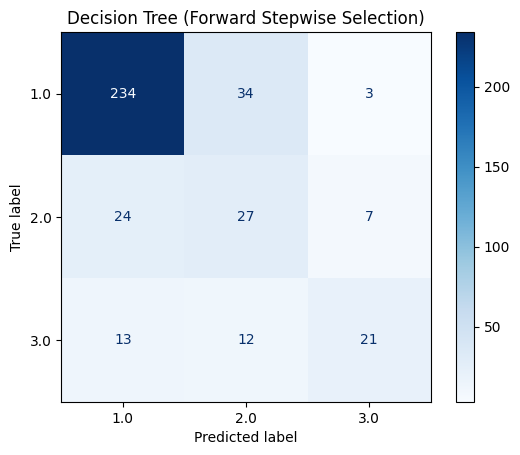


Classification Report Decision Tree FSS:

              precision    recall  f1-score   support

         1.0       0.86      0.86      0.86       271
         2.0       0.37      0.47      0.41        58
         3.0       0.68      0.46      0.55        46

    accuracy                           0.75       375
   macro avg       0.64      0.60      0.61       375
weighted avg       0.76      0.75      0.75       375


Forward Stepwise Selection DT AUC-ROC skóre pre jednotlivé foldy: [0.69279 0.72514 0.69746 0.75326 0.73291]
Forward Stepwise Selection Decision Tree priemerné AUC-ROC: 0.72031


In [22]:
#### Model DecisionTree na vybraných atribútov z FFS pre LR. ####
dt_fwd = DecisionTreeClassifier(random_state=42)
dt_fwd.fit(X_train[selected_features], y_train)
y_pred_dt_fwd = dt_fwd.predict(X_test[selected_features])

ConfusionMatrixDisplay.from_estimator(dt_fwd, X_test[selected_features], y_test, cmap="Blues")
plt.title("Decision Tree (Forward Stepwise Selection)")
plt.show()

print("\nClassification Report Decision Tree FSS:\n")
print(classification_report(y_test, y_pred_dt_fwd))

fwd_dt_auc_scores = cross_val_score(DecisionTreeClassifier(random_state=42),X_train[selected_features],y_train,cv=cv_folds,scoring='roc_auc_ovr')

print("\nForward Stepwise Selection DT AUC-ROC skóre pre jednotlivé foldy:", fwd_dt_auc_scores.round(5))
print("Forward Stepwise Selection Decision Tree priemerné AUC-ROC:", fwd_dt_auc_scores.mean().round(5))

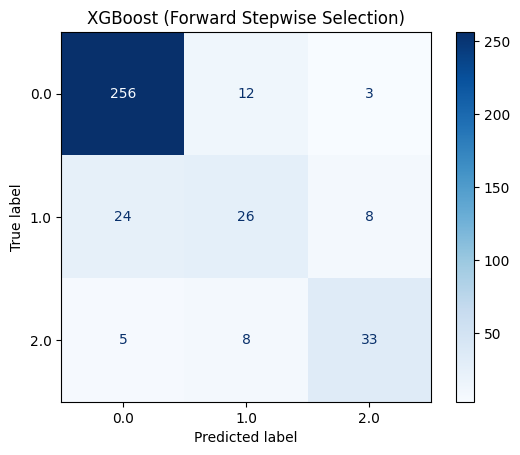


Classification Report XGBoost FSS:

              precision    recall  f1-score   support

         1.0       0.90      0.94      0.92       271
         2.0       0.57      0.45      0.50        58
         3.0       0.75      0.72      0.73        46

    accuracy                           0.84       375
   macro avg       0.74      0.70      0.72       375
weighted avg       0.83      0.84      0.83       375

Forward Stepwise Selection XGBoost AUC-ROC skóre pre jednotlivé foldy: [0.876   0.87697 0.89485 0.96135 0.89366]
Forward Stepwise Selection XGBoost priemerné AUC-ROC: 0.90057


In [23]:
#### Model XGBoost na vybraných atribútov z FFS pre LR. ####
#Potrebujeme upraviť indexy pre pracu ako v pôvodnom modely.
y_train_adj = y_train - 1
y_test_adj = y_test - 1

xgb_fwd = XGBClassifier(n_estimators=100, random_state=42)
xgb_fwd.fit(X_train[selected_features], y_train_adj)
y_pred_xgb_fwd = xgb_fwd.predict(X_test[selected_features])

#Spätná transformácia.
y_pred_xgb_original = y_pred_xgb_fwd + 1

ConfusionMatrixDisplay.from_estimator(xgb_fwd, X_test[selected_features], y_test_adj, cmap="Blues")
plt.title("XGBoost (Forward Stepwise Selection)")
plt.show()

print("\nClassification Report XGBoost FSS:\n")
print(classification_report(y_test, y_pred_xgb_original))

fwd_xgb_auc_scores = cross_val_score(XGBClassifier(n_estimators=100, random_state=42),X_train[selected_features],y_train - 1,cv=cv_folds,scoring='roc_auc_ovr')

print("Forward Stepwise Selection XGBoost AUC-ROC skóre pre jednotlivé foldy:", fwd_xgb_auc_scores.round(5))
print("Forward Stepwise Selection XGBoost priemerné AUC-ROC:", fwd_xgb_auc_scores.mean().round(5))

In [24]:
print("Priemerné AUC-ROC pre Logistickú regresiu (Forward Stepwise Selection):", fwd_lr_auc_scores.mean().round(5))
print("\nPriemerné AUC-ROC pre GBM (Forward Stepwise Selection):", fwd_gbm_auc_scores.mean().round(5), "\n")
print("Priemerné AUC-ROC pre Decision Tree (Forward Stepwise Selection):", fwd_dt_auc_scores.mean().round(5), "\n")
print("Priemerné AUC-ROC pre XGB (Forward Stepwise Selection):", fwd_xgb_auc_scores.mean().round(5), "\n")

Priemerné AUC-ROC pre Logistickú regresiu (Forward Stepwise Selection): 0.84537

Priemerné AUC-ROC pre GBM (Forward Stepwise Selection): 0.89954 

Priemerné AUC-ROC pre Decision Tree (Forward Stepwise Selection): 0.72031 

Priemerné AUC-ROC pre XGB (Forward Stepwise Selection): 0.90057 



In [25]:
#Inicializácia Decision Tree ako základného modelu pre spätný výber atribútov.
base_estimator_bwd_dt = DecisionTreeClassifier(random_state=42)
sfs_backward_dt = SequentialFeatureSelector(base_estimator_bwd_dt,
    n_features_to_select="auto",direction='backward',scoring='accuracy',cv=5,n_jobs=-1,tol=0)

#Trénovanie backward feature Elimination na trénovacích dátach.
sfs_backward_dt.fit(X_train, y_train)

#Vybrané atribúty z Decision Tree Backward Stepwise Elimination.
selected_features_dt = X_train.columns[sfs_backward_dt.get_support()]
print("\nVybrané atribúty z Backward stepwise elimination pre všetky modely:\n", selected_features_dt)


Vybrané atribúty z Backward stepwise elimination pre všetky modely:
 Index(['Vek', 'Alkohol', 'S-Na first', 'S-Na last', 'S-Na min', 'S-Na max',
       'S-K first', 'S-K last', 'S-K min', 'S-K max', 'S-CL first',
       'S-CL last', 'S-CL min', 'S-CL max', 'S-CRP first', 'S-CRP last',
       'S-CRP min', 'S-CRP max', 'S-CK-MB first', 'S-CK-MB last',
       'S-CK-MB min', 'S-IL6 first', 'S-IL6 last', 'S-IL6 min', 'S-IL6 max',
       'HGB first', 'HGB last', 'HGB min', 'HGB max', 'WBC first', 'WBC last',
       'WBC min', 'WBC max', 'PLT first', 'PLT last', 'PLT min', 'PLT max',
       'Neu abs first', 'Neu abs last', 'Neu abs min', 'PT (INR) last',
       'PT (INR) min', 'PT (INR) max', 'APTT-R first', 'APTT-R last',
       'APTT-R min', 'APTT-R max', 'Fib first', 'Fib last', 'Fib min',
       'Fib max', 'NE/LY(NLR) first', 'NE/LY(NLR) last', 'NE/LY(NLR) min',
       'NE/LY(NLR) max', 'D-dimér HS first', 'D-dimér HS last',
       'D-dimér HS min', 'D-dimér HS max', 'SatO2 %', 'Hyperten

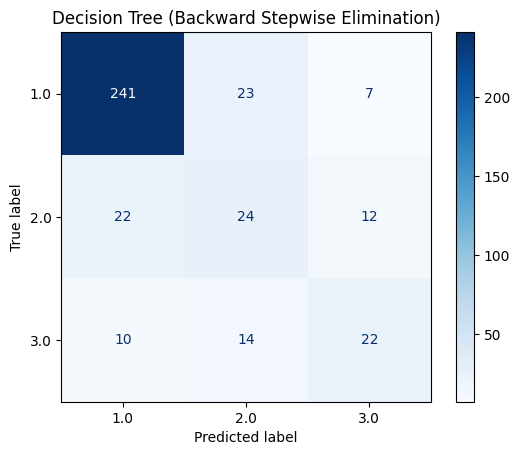


Decision Tree (Backward Stepwise Elimination) AUC-ROC foldy: [0.73628 0.7623  0.75936 0.7816  0.77821]
Priemer AUC-ROC pre Decision Tree (Backward Stepwise Elimination) 0.76355


In [26]:
#### Model Decision Tree na vybraných atribútov z Backward Stepwise Elimination. ####
dt_bwd = DecisionTreeClassifier(random_state=42)
#Trénovanie modelu na dátach s len vybranými atribútmi pomocou Backward Stepwise Elimination.
dt_bwd.fit(X_train[selected_features_dt], y_train)
y_pred_dt_bwd = dt_bwd.predict(X_test[selected_features_dt])

ConfusionMatrixDisplay.from_estimator(dt_bwd, X_test[selected_features_dt], y_test, cmap="Blues")
plt.title("Decision Tree (Backward Stepwise Elimination)")
plt.show()

dt_bwd_auc = cross_val_score(DecisionTreeClassifier(random_state=42),X_train[selected_features_dt],y_train,cv=cv_folds,scoring='roc_auc_ovr')

print("\nDecision Tree (Backward Stepwise Elimination) AUC-ROC foldy:", dt_bwd_auc.round(5))
print("Priemer AUC-ROC pre Decision Tree (Backward Stepwise Elimination)", dt_bwd_auc.mean().round(5))

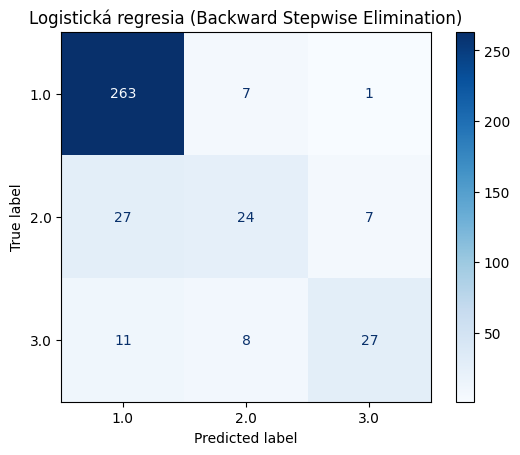


Logistická regresia (Backward Stepwise Elimination) AUC-ROC foldy: [0.8118  0.88487 0.85597 0.91333 0.84782]
Priemer AUC-ROC pre Logistická regresia (Backward Stepwise Elimination): 0.86276


In [27]:
#### Model LR na vybraných atribútov z Backward Stepwise Elimination pre DT. ####

lr_bwd = OneVsRestClassifier(LogisticRegression(solver='liblinear', max_iter=1000, random_state=42))
#Trénovanie modelu na škálovaných dátach s vybranými atribútmi.
lr_bwd.fit(X_train_scaled[selected_features_dt], y_train)
y_pred_lr_bwd = lr_bwd.predict(X_test_scaled[selected_features_dt])

ConfusionMatrixDisplay.from_estimator(lr_bwd, X_test_scaled[selected_features_dt], y_test, cmap="Blues")
plt.title("Logistická regresia (Backward Stepwise Elimination)")
plt.show()

lr_bwd_auc = cross_val_score(lr_bwd,X_train_scaled[selected_features_dt],y_train,cv=cv_folds,scoring='roc_auc_ovr')
print("\nLogistická regresia (Backward Stepwise Elimination) AUC-ROC foldy:", lr_bwd_auc.round(5))
print("Priemer AUC-ROC pre Logistická regresia (Backward Stepwise Elimination):", lr_bwd_auc.mean().round(5))

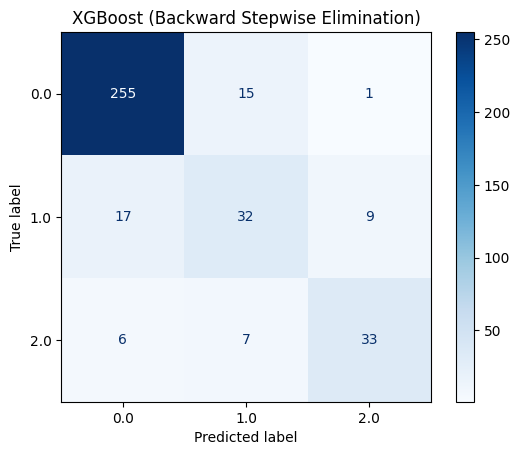


XGBoost (Backward Stepwise Elimination) AUC-ROC foldy: [0.91626 0.95998 0.95942 0.95682 0.93383]
Priemer AUC-ROC pre XGBoost (Backward Stepwise Elimination): 0.94526


In [28]:
#### Model XGBoost na vybraných atribútov z Backward Stepwise Elimination pre DT. ####

xgb_bwd = XGBClassifier(n_estimators=100, random_state=42)
xgb_bwd.fit(X_train[selected_features_dt], y_train-1)
y_pred_xgb_bwd = xgb_bwd.predict(X_test[selected_features_dt]) + 1

ConfusionMatrixDisplay.from_estimator(xgb_bwd, X_test[selected_features_dt], y_test-1, cmap="Blues")
plt.title("XGBoost (Backward Stepwise Elimination)")
plt.show()

xgb_bwd_auc = cross_val_score(XGBClassifier(n_estimators=100, random_state=42),X_train[selected_features_dt],y_train-1,cv=cv_folds,scoring='roc_auc_ovr')

print("\nXGBoost (Backward Stepwise Elimination) AUC-ROC foldy:", xgb_bwd_auc.round(5))
print("Priemer AUC-ROC pre XGBoost (Backward Stepwise Elimination):", xgb_bwd_auc.mean().round(5))

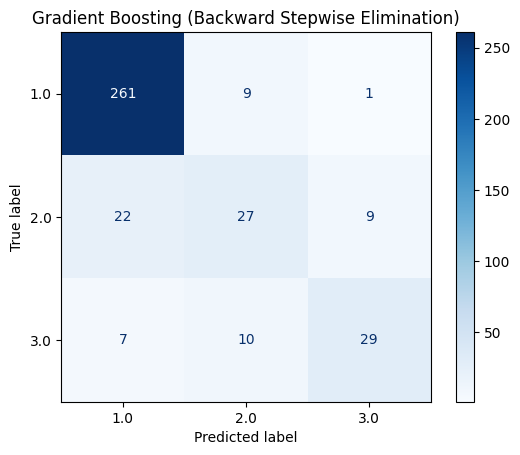


GBM (Backward Stepwise Elimination) AUC-ROC foldy: [0.89333 0.95598 0.95969 0.94112 0.94165]
Priemer AUC-ROC pre GBM (Backward Stepwise Elimination): 0.93835


In [29]:
#### Model GBM na vybraných atribútov z Backward Stepwise Elimination pre DT. ####

gbm_bwd = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbm_bwd.fit(X_train[selected_features_dt], y_train)
y_pred_gbm_bwd = gbm_bwd.predict(X_test[selected_features_dt])

ConfusionMatrixDisplay.from_estimator(gbm_bwd, X_test[selected_features_dt], y_test, cmap="Blues")
plt.title("Gradient Boosting (Backward Stepwise Elimination)")
plt.show()

gbm_bwd_auc = cross_val_score(GradientBoostingClassifier(n_estimators=100, random_state=42),X_train[selected_features_dt],y_train,cv=cv_folds,scoring='roc_auc_ovr')

print("\nGBM (Backward Stepwise Elimination) AUC-ROC foldy:", gbm_bwd_auc.round(5))
print("Priemer AUC-ROC pre GBM (Backward Stepwise Elimination):", gbm_bwd_auc.mean().round(5))

In [30]:
print("Priemerné AUC-ROC pre Logistickú regresiu (Backward Stepwise Elimination):", lr_bwd_auc.mean().round(5))
print("\nPriemerné AUC-ROC pre GBM (Backward Stepwise Elimination):", gbm_bwd_auc.mean().round(5), "\n")
print("Priemerné AUC-ROC pre Decision Tree (Backward Stepwise Elimination):", dt_bwd_auc.mean().round(5), "\n")
print("Priemerné AUC-ROC pre XGB (Backward Stepwise Elimination):", xgb_bwd_auc.mean().round(5), "\n")

Priemerné AUC-ROC pre Logistickú regresiu (Backward Stepwise Elimination): 0.86276

Priemerné AUC-ROC pre GBM (Backward Stepwise Elimination): 0.93835 

Priemerné AUC-ROC pre Decision Tree (Backward Stepwise Elimination): 0.76355 

Priemerné AUC-ROC pre XGB (Backward Stepwise Elimination): 0.94526 



In [31]:
data = []
#Všetky atribúty.
data.append(["LogisticRegression", "All features", lr_auc_scores])
data.append(["GBM",                "All features", gbm_auc_scores])
data.append(["Decision Tree",      "All features", tree_auc_scores])
data.append(["XGB",                "All features", xgb_auc_scores])
#Forward Stepwise Selection.
data.append(["LogisticRegression", "Forward Stepwise Selection", fwd_lr_auc_scores])
data.append(["GBM",                "Forward Stepwise Selection", fwd_gbm_auc_scores])
data.append(["Decision Tree",      "Forward Stepwise Selection", fwd_dt_auc_scores])
data.append(["XGB",                "Forward Stepwise Selection", fwd_xgb_auc_scores])
#Backward Stepwise Elimination.
data.append(["LogisticRegression", "Backward Stepwise Elimination", lr_bwd_auc])
data.append(["GBM",                "Backward Stepwise Elimination", gbm_bwd_auc])
data.append(["Decision Tree",      "Backward Stepwise Elimination", dt_bwd_auc])
data.append(["XGB",                "Backward Stepwise Elimination", xgb_bwd_auc])

df_auc_porovanie = pd.DataFrame(data, columns=["Model", "Výber", "AUC-ROC foldy"])
print("\nPorovnanie AUC-ROC foldov pre všetky modely a každy typ výberu atribútov\n")
print(df_auc_porovanie.to_string(index=False))


Porovnanie AUC-ROC foldov pre všetky modely a každy typ výberu atribútov

             Model                         Výber                                                                                        AUC-ROC foldy
LogisticRegression                  All features [0.8098019619435224, 0.8870723651447028, 0.8585384379029698, 0.9196493457548162, 0.8541147700309221]
               GBM                  All features   [0.8952133744802676, 0.9532475148931709, 0.95958598677215, 0.9419261337837593, 0.9431397128317897]
     Decision Tree                  All features  [0.6487452087071403, 0.7478351147272053, 0.7269908565561044, 0.7756858228987317, 0.775617557353054]
               XGB                  All features    [0.921888384504407, 0.963014485345454, 0.9524264573404357, 0.944904337785434, 0.9377382432725012]
LogisticRegression    Forward Stepwise Selection [0.8039116259094268, 0.8338078970082542, 0.8446928539081976, 0.8899180460929187, 0.8545011566065145]
               GBM    For

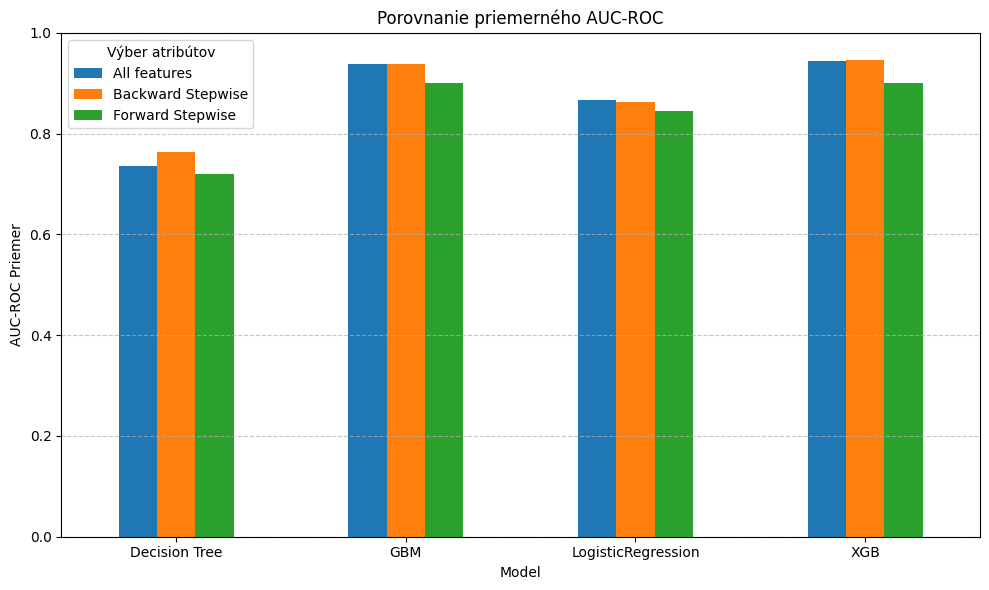

In [32]:
#Porovnanie výsledkov, každý záznam obsahuje názov modelu, metódu výberu atribútov a priemerné AUC-ROC.
data = [
    ["LogisticRegression", "All features", lr_auc_scores.mean()],
    ["Decision Tree", "All features", tree_auc_scores.mean()],
    ["XGB", "All features", xgb_auc_scores.mean()],
    ["GBM", "All features", gbm_auc_scores.mean()],
    ["LogisticRegression", "Forward Stepwise", fwd_lr_auc_scores.mean()],
    ["Decision Tree", "Forward Stepwise", fwd_dt_auc_scores.mean()],
    ["XGB", "Forward Stepwise", fwd_xgb_auc_scores.mean()],
    ["GBM", "Forward Stepwise", fwd_gbm_auc_scores.mean()],
    ["LogisticRegression", "Backward Stepwise", lr_bwd_auc.mean()],
    ["Decision Tree", "Backward Stepwise", dt_bwd_auc.mean()],
    ["XGB", "Backward Stepwise", xgb_bwd_auc.mean()],
    ["GBM", "Backward Stepwise", gbm_bwd_auc.mean()]]

#Vloženie dát do DF.
df = pd.DataFrame(data, columns=["Model", "Feature Selection", "AUC-ROC (mean)"])

#Modely na osi x, metódy výberu atribútov ako farebné stlpce.
df_wide = df.pivot(index="Model", columns="Feature Selection", values="AUC-ROC (mean)")

#Vykreslenie grafu.
df_wide.plot(kind="bar", figsize=(10, 6), rot= 0)
plt.title("Porovnanie priemerného AUC-ROC")
plt.xlabel("Model")
plt.ylabel("AUC-ROC Priemer")
plt.ylim(0, 1)
plt.legend(title="Výber atribútov")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

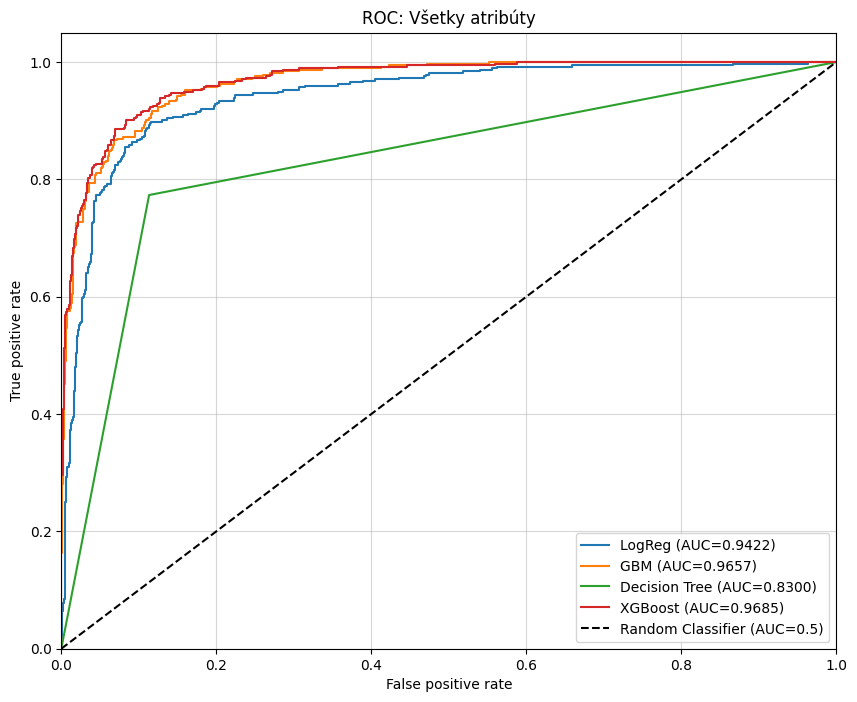

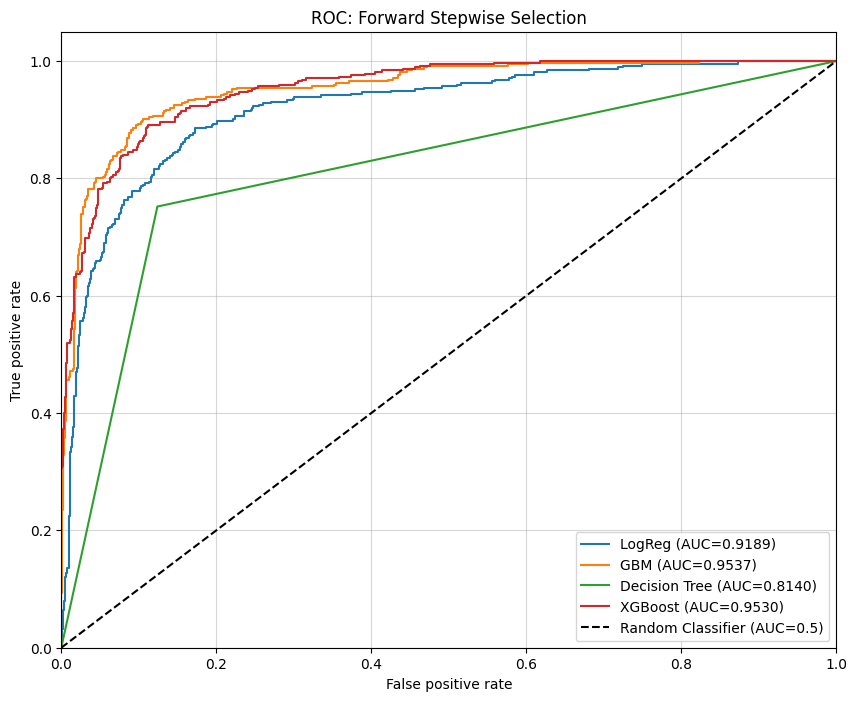

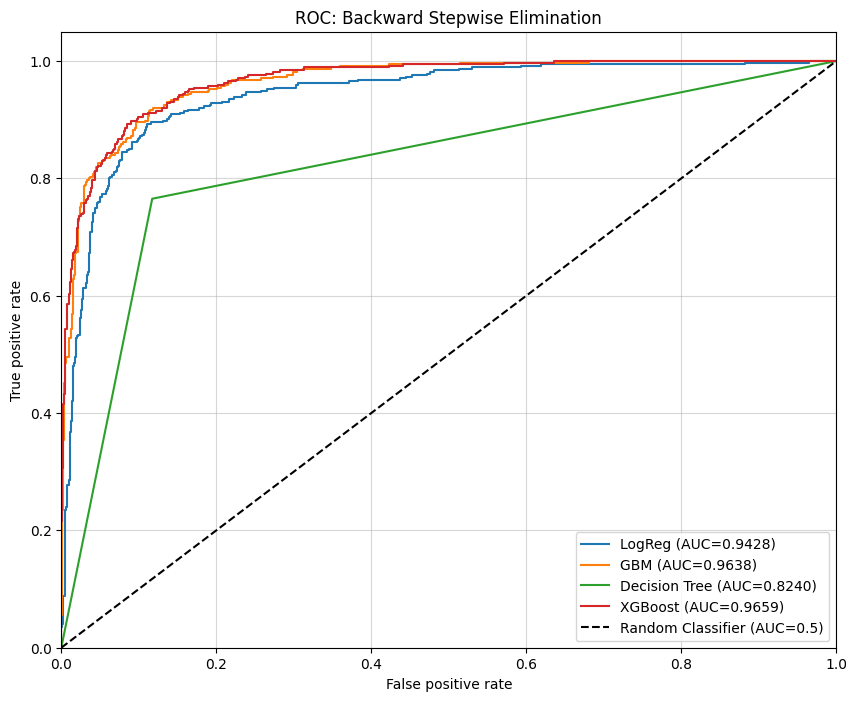

In [33]:
# Knižnice pre ROC krivky a grafy
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

#Funkcia na vykreslenie ROC kriviek pre viacero modelov.
def plot_roc_comparison(model_list, y_true, title):
    #Vytvoríme nový graf.
    plt.figure(figsize=(10, 8))
    #Prevedieme skutočné triedy do binárneho formátu.
    y_bin = label_binarize(y_true, classes=[1, 2, 3])
    # Pre každý model vykreslíme ROC krivku
    for name, model, X_test in model_list:
            #Pravdepodobnosti pre triedy.
            probas = model.predict_proba(X_test)
            #Výpočet ROC krivky.
            fpr, tpr, _ = roc_curve(y_bin.ravel(), probas.ravel())
            #Výpočet AUC.
            roc_auc = auc(fpr, tpr)
            #Vykreslenie krivky.
            plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.4f})')

    # Vykreslíme náhodný klasifikátor
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC=0.5)')

    # Nastavenie grafu
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()

#Modely, kde používame všetky atribúty.
models_all = [('LogReg', lr_model, X_test_scaled),('GBM', gbm, X_test),('Decision Tree', tree, X_test),('XGBoost', xgb, X_test)]

plot_roc_comparison(models_all, y_test, 'ROC: Všetky atribúty')

#Modely, kde používame FSS.
models_fwd = [('LogReg', model_fwd, X_test_fwd),('GBM', gbm_fwd, X_test[selected_features]),('Decision Tree', dt_fwd, X_test[selected_features]),('XGBoost', xgb_fwd, X_test[selected_features])]

plot_roc_comparison(models_fwd, y_test, 'ROC: Forward Stepwise Selection')

#Modely, kde používame Backward Stepwise Elimination.
models_bwd = [('LogReg', lr_bwd, X_test_scaled[selected_features_dt]),('GBM', gbm_bwd, X_test[selected_features_dt]),('Decision Tree', dt_bwd, X_test[selected_features_dt]),('XGBoost', xgb_bwd, X_test[selected_features_dt])]

plot_roc_comparison(models_bwd, y_test, 'ROC: Backward Stepwise Elimination')